In [2]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

base_path = Path(r"I:\Dokumente\Bachelor Thesis\Thesis\Simulator\Datasets\Smart meters in London")

In [3]:
path_acorn_csv = base_path / 'data' / 'informations_households.csv'
assert path_acorn_csv.exists(), f"File not found: {path_acorn_csv}"

lookup_dict = {}
lookup_df = pd.read_csv(path_acorn_csv)

# Drop all rows with Acorn not in [ACORN-A, ... , ACORN-V]
lookup_df = lookup_df[lookup_df['Acorn'].str.match(r'ACORN-[A-Z]')]
lookup_df = lookup_df[['LCLid', 'Acorn', 'Acorn_grouped']]
lookup_df.head()

,LCLid,Acorn,Acorn_grouped
2,MAC000002,ACORN-A,Affluent
3,MAC003613,ACORN-A,Affluent
4,MAC003597,ACORN-A,Affluent
5,MAC003579,ACORN-A,Affluent
6,MAC003566,ACORN-A,Affluent


In [38]:
day_df = pd.read_csv(base_path / 'data/processed.csv')
value_columns = [f'{i:02}:00' for i in range(0,24)]

# Add columns for the Acorn and Acorn_grouped
day_df['Acorn'] = day_df['LCLid'].map(lookup_df.set_index('LCLid')['Acorn'])
day_df['Acorn_grouped'] = day_df['LCLid'].map(lookup_df.set_index('LCLid')['Acorn_grouped'])

# Drop NaN values
day_df = day_df.dropna(subset=['Acorn'])

# Pick date with most data
date = day_df['date'].value_counts().idxmax()
day_df = day_df[day_df['date'] == date]
print(date, day_df.shape)

print(day_df.value_counts('Acorn')/day_df['Acorn'].count())
print(day_df.shape)


# Split into training and test set. Preserve Acorn distribution
train_df, test_df = train_test_split(day_df, test_size=0.4, stratify=day_df['Acorn'])
print(train_df.value_counts('Acorn')/train_df['Acorn'].count())
print(train_df.shape)
print(test_df.value_counts('Acorn')/test_df['Acorn'].count())
print(test_df.shape)

2012-10-31 (991, 28)
Acorn
ACORN-E    0.374369
ACORN-D    0.294652
ACORN-A    0.156408
ACORN-C    0.149344
ACORN-B    0.025227
Name: count, dtype: float64
(991, 28)
Acorn
ACORN-E    0.373737
ACORN-D    0.294613
ACORN-A    0.156566
ACORN-C    0.149832
ACORN-B    0.025253
Name: count, dtype: float64
(594, 28)
Acorn
ACORN-E    0.375315
ACORN-D    0.294710
ACORN-A    0.156171
ACORN-C    0.148615
ACORN-B    0.025189
Name: count, dtype: float64
(397, 28)


<Axes: xlabel='sum_day'>

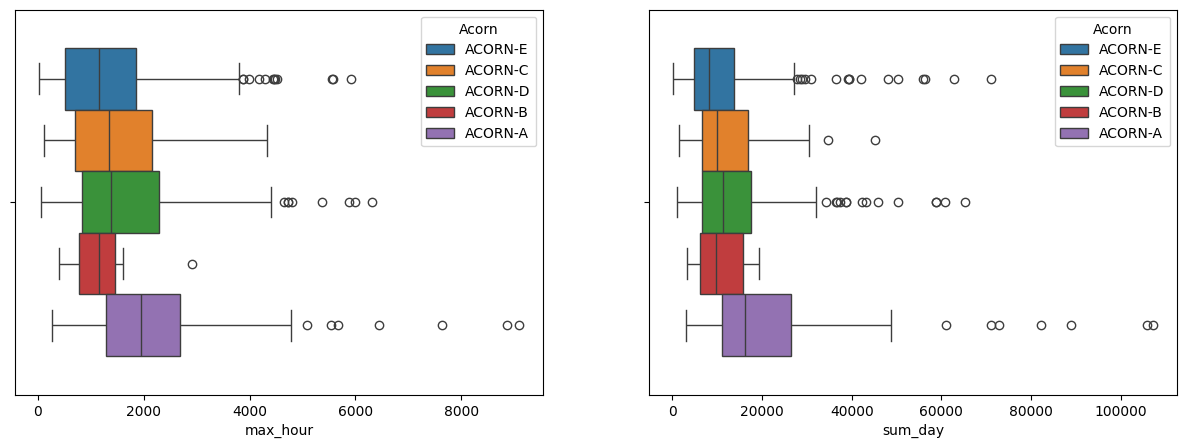

In [ ]:
temp_df = train_df.copy()
temp_df['min_hour'] = temp_df[value_columns].min(axis=1)
temp_df['max_hour'] = temp_df[value_columns].max(axis=1)
temp_df['sum_day'] = temp_df[value_columns].sum(axis=1)

# Plot the distribution of max_hour grouped by Acorn
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=temp_df, x='max_hour', hue='Acorn', ax=ax[0])
sns.boxplot(data=temp_df, x='sum_day', hue='Acorn', ax=ax[1])

m0   m1 (New Previous)    m2 Previous          m3 Current          m4 Verifier      m5 (New Current)           m6 (New Verifier)

In [69]:
# Get boxplot data
box_data = temp_df.groupby('Acorn')['sum_day'].describe()
# IQR and cutoff
box_data['IQR'] = box_data['75%'] - box_data['25%']
box_data['cutoff'] = box_data['75%'] + 1.5 * box_data['IQR']
box_data.to_csv(base_path / 'data' / 'boxplot_data.csv')
box_data

,count,mean,std,min,25%,50%,75%,max,IQR,cutoff
Acorn,,,,,,,,,,
ACORN-A,93.0,22436.591398,20309.290681,3041.0,10986.0,16097.0,26343.00,107289.0,15357.00,49378.500
ACORN-B,15.0,10595.600000,5179.465248,3209.0,6261.0,9724.0,15719.50,19218.0,9458.50,29907.250
ACORN-C,89.0,12285.752809,7985.315713,1432.0,6532.0,9996.0,16867.00,45181.0,10335.00,32369.500
ACORN-D,175.0,14340.011429,12045.560845,937.0,6504.5,11213.0,17575.50,65224.0,11071.00,34182.000
ACORN-E,222.0,11292.270270,11026.750428,121.0,4900.5,8085.5,13831.75,71162.0,8931.25,27228.625


In [51]:
test_df.to_csv(base_path / 'data' / 'sm_data_manipultion_test.csv')

In [68]:
# Get cutoff from boxplot data for ACORN-A
cutoff = box_data.loc['ACORN-C', 'cutoff']
int(cutoff + 0.5)

4358

In [11]:
day_df = pd.read_csv(base_path / 'data/processed.csv')
value_columns = [f'{i:02}:00' for i in range(0,24)]
threshold_df = pd.DataFrame(columns=['LCLid', 'Q0', 'Q1', 'Q2', 'Q3', 'Q4', 'mean'])

day_df['day_sum'] = day_df[value_columns].sum(axis=1)
for sm in day_df['LCLid'].unique():
    sm_data = day_df[day_df['LCLid'] == sm]
    sm_data = sm_data['day_sum'].sort_values()
    q0 = sm_data.iloc[0]
    q1 = sm_data.quantile(0.25)
    q2 = sm_data.quantile(0.5)
    q3 = sm_data.quantile(0.75)
    q4 = sm_data.iloc[-1]
    mean = sm_data.mean()
    threshold_df.loc[len(threshold_df)] = [sm, q0, q1, q2, q3, q4, mean]
display(threshold_df.head())
display(threshold_df.describe())

,LCLid,Q0,Q1,Q2,Q3,Q4,mean
0,MAC000002,4548,9382.50,11221.0,13795.50,39281,12119.389662
1,MAC000246,3571,11273.00,16494.0,21101.00,47165,16846.392901
2,MAC000450,36933,59191.00,70962.0,82573.00,138112,72745.177458
3,MAC001074,13708,19803.75,22959.0,26322.75,38037,23283.308036
4,MAC003223,4231,16203.75,19119.5,22143.75,45780,19206.899621


,Q0,Q1,Q2,Q3,Q4,mean
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,3850.149149,9521.613363,12501.093594,16179.887387,35598.188188,13183.447553
std,4113.584329,7661.566561,9950.921108,13354.915258,30256.804369,10400.445653
min,0.000000,0.000000,0.000000,655.000000,2386.000000,400.411371
25%,1560.000000,4745.250000,6202.500000,7694.625000,17392.000000,6616.261133
50%,2934.000000,7770.000000,10085.000000,12814.500000,27545.000000,10738.721768
75%,4790.500000,12174.875000,16080.500000,20317.875000,44414.500000,16815.398841
max,61940.000000,85217.000000,97888.000000,140276.500000,332538.000000,101323.778980


In [49]:
temp_df = threshold_df.copy()
temp_df['group'] = pd.qcut(temp_df['mean'], 30)
# Mean of the groups
temp_df['threshold_soft'] = temp_df['group'].apply(lambda x: x.right * 3).astype(int)
temp_df['threshold_hard'] = temp_df['group'].apply(lambda x: x.right * 2).astype(int)
temp_df.to_csv(base_path / 'data' / 'threshold_data.csv')
temp_df.head()


,LCLid,Q0,Q1,Q2,Q3,Q4,mean,group,threshold_soft,threshold_hard
0,MAC000002,4548,9382.50,11221.0,13795.50,39281,12119.389662,"(11804.887, 12373.386]",37120,24746
1,MAC000246,3571,11273.00,16494.0,21101.00,47165,16846.392901,"(16359.679, 17209.182]",51627,34418
2,MAC000450,36933,59191.00,70962.0,82573.00,138112,72745.177458,"(37194.662, 101323.779]",303971,202647
3,MAC001074,13708,19803.75,22959.0,26322.75,38037,23283.308036,"(21533.144, 24104.464]",72313,48208
4,MAC003223,4231,16203.75,19119.5,22143.75,45780,19206.899621,"(18317.106, 19494.994]",58484,38989
